In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,log_loss, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")


In [2]:
# # 데이터 경로 설정
# base_path = 'resized_feature'
# save_path_contours = 'contours_feature'  # 윤곽선만 저장할 경로

# # 얼굴 부위 및 피부 상태 설정
# face_parts = ['cheek', 'forehead', 'nose']

# # 이미지 윤곽선 저장
# for part in face_parts:
#     for data_split in ['resized_train', 'resized_test']:
#         folder_path = os.path.join(base_path, data_split, part)
#         save_path_contours_part = os.path.join(save_path_contours, data_split, part)
#         os.makedirs(save_path_contours_part, exist_ok=True)

#         for filename in os.listdir(folder_path):
#             img_path = os.path.join(folder_path, filename)

#             # 이미지 로드 및 전처리
#             image_to_segment = cv2.imread(img_path)
#             image_to_segment = cv2.cvtColor(image_to_segment, cv2.COLOR_BGR2RGB)
#             image_to_segment = cv2.resize(image_to_segment, (128, 128))

#             # 윤곽선을 찾기 위한 코드
#             dst_img = np.zeros_like(image_to_segment)

#             # 각 채널에 대해 윤곽선을 찾습니다.
#             for i in range(3):  # 3개의 채널(BGR)에 대해 반복
#                 channel = image_to_segment[:, :, i]  # 각 채널 선택
#                 ret, otsu = cv2.threshold(channel, -1, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#                 contours, hier = cv2.findContours(otsu, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

#                 COLOR = (0, 200, 2)
#                 cv2.drawContours(dst_img, contours, -1, COLOR, 2)

#             # 윤곽선을 저장할 경로 설정
#             save_path_contours = os.path.join(save_path_contours_part, filename)
#             os.makedirs(os.path.dirname(save_path_contours), exist_ok=True)

#             # 윤곽선 저장
#             cv2.imwrite(save_path_contours, dst_img)

In [3]:
# 데이터 경로 설정
base_path = 'resized_feature'

# 얼굴 부위 및 피부 상태 설정
face_parts = ['forehead', 'nose', 'cheek']
data_types = ['resized_train', 'resized_test']

# 데이터 불러오기
data = []
labels = []

for part in face_parts:
    for data_type in data_types:
        folder_path = os.path.join(base_path, data_type, part)

        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)

            if os.path.isfile(img_path):
                img = cv2.imread(img_path)

                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (128, 128))

                    data.append(img)
                    labels.append(f'{part}') 
                else:
                    print(f"Warning: Unable to read the image at {img_path}")

                    
# 데이터와 레이블을 numpy 배열로 변환
data = np.array(data)
labels = np.array(labels)

# 레이블 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

if data.shape[0] > 0 and encoded_labels.size > 0:
    # 레이블 인코딩
    encoded_labels = to_categorical(encoded_labels)

    # 데이터 분할 (8:2 비율)
    X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.2, random_state=42)
else:
    print("Error: No data or labels to split.")

In [4]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128,128, 3))

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
23/23 [==============================] - 268s 11s/step - loss: 0.2279 - accuracy: 0.9194 - val_loss: 0.1692 - val_accuracy: 0.9556
Epoch 2/100
23/23 [==============================] - 200s 9s/step - loss: 0.1129 - accuracy: 0.9681 - val_loss: 0.1164 - val_accuracy: 0.9667
Epoch 3/100
23/23 [==============================] - 183s 8s/step - loss: 0.0677 - accuracy: 0.9778 - val_loss: 0.7720 - val_accuracy: 0.8389
Epoch 4/100
23/23 [==============================] - 147s 6s/step - loss: 0.0431 - accuracy: 0.9903 - val_loss: 0.3081 - val_accuracy: 0.9389
Epoch 5/100
23/23 [==============================] - 163s 7s/step - loss: 0.0279 - accuracy: 0.9931 - val_loss: 0.4415 - val_accuracy: 0.9278
Epoch 6/100
23/23 [==============================] - 164s 7s/step - loss: 0.0348 - accuracy: 0.9847 - val_loss: 1.3719 - val_accuracy: 0.8833
Epoch 7/100
23/23 [==============================] - 125s 5s/step - loss: 0.0396 - accuracy: 0.9889 - val_loss: 0.4320 - val_accuracy: 0.9056
Epoch

23/23 [==============================] - 117s 5s/step - loss: 0.0016 - accuracy: 0.9986 - val_loss: 0.1035 - val_accuracy: 0.9722
Epoch 59/100
23/23 [==============================] - 138s 6s/step - loss: 1.1945e-04 - accuracy: 1.0000 - val_loss: 0.0984 - val_accuracy: 0.9778
Epoch 60/100
23/23 [==============================] - 167s 7s/step - loss: 4.2226e-05 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.9778
Epoch 61/100
23/23 [==============================] - 173s 8s/step - loss: 2.0046e-05 - accuracy: 1.0000 - val_loss: 0.0822 - val_accuracy: 0.9778
Epoch 62/100
23/23 [==============================] - 159s 7s/step - loss: 0.0011 - accuracy: 0.9986 - val_loss: 0.1201 - val_accuracy: 0.9722
Epoch 63/100
23/23 [==============================] - 169s 7s/step - loss: 1.1613e-04 - accuracy: 1.0000 - val_loss: 0.1215 - val_accuracy: 0.9722
Epoch 64/100
23/23 [==============================] - 188s 8s/step - loss: 1.6340e-04 - accuracy: 1.0000 - val_loss: 0.1115 - val_accuracy:

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 4, 4, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 4,706,982
Trainable params: 4,664,959
Non-trainable params: 42,023
_________________________________________________________________


In [6]:
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 예측 결과 출력
for i in range(5):  # 예측 결과 중에서 처음 5개만 출력
    predicted_class = label_encoder.classes_[np.argmax(y_pred[i])]
    actual_class = label_encoder.classes_[np.argmax(y_test[i])]
    print(f'Actual: {actual_class}, Predicted: {predicted_class}')

6/6 [==============================] - 8s 1s/step - loss: 0.0964 - accuracy: 0.9889
Test Loss: 0.09644048660993576, Test Accuracy: 0.9888888597488403
Actual: forehead, Predicted: forehead
Actual: cheek, Predicted: cheek
Actual: forehead, Predicted: forehead
Actual: nose, Predicted: nose
Actual: forehead, Predicted: forehead


In [14]:
# One-hot 인코딩된 레이블을 다시 범주형 레이블로 변환
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# 정밀도(Precision)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
print(f'Precision: {precision}')

# 재현율(Recall)
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
print(f'Recall: {recall}')

# F1 score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f'F1 Score: {f1}')

y_pred_proba = model.predict_proba(X_test)  # 긍정 클래스에 대한 확률 추정

# 로그 손실(Log Loss)
logloss = log_loss(y_test, y_pred_proba)
print(f'Log Loss: {logloss}')

Precision: 0.9890828442285636
Recall: 0.9888888888888889
F1 Score: 0.9888536311858317
Log Loss: 0.09644048306379871


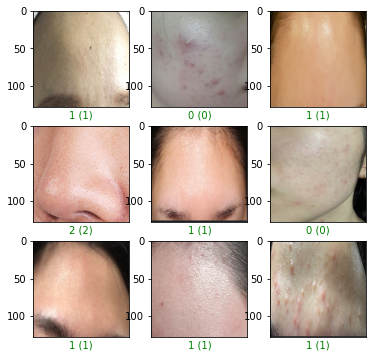

In [8]:
# 예측 결과 시각화
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(X_test[i], cmap=plt.cm.binary)
    plt.xticks([])
    plt.yticks()
    predicted_label = np.argmax(y_pred[i])
    true_label = np.argmax(y_test[i])
    if np.array_equal(predicted_label, true_label):
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("{} ({})".format(predicted_label, true_label), color=color)
plt.show()

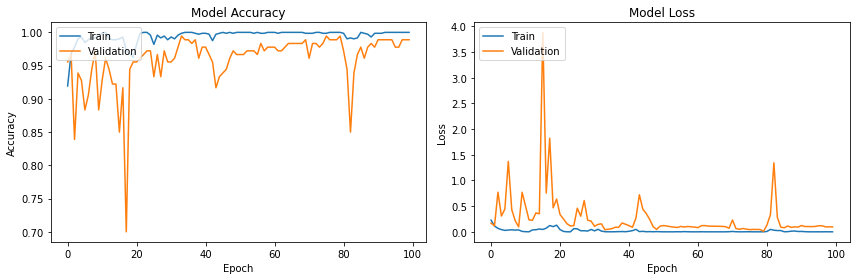

In [9]:
# 손실 및 정확도 그래프 생성
def plot_training_history(history):
    # 전체 창의 크기 설정
    plt.figure(figsize=(12, 4))

    # 훈련 및 검증 정확도 값 플롯
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])  # 훈련 정확도
    plt.plot(history.history['val_accuracy'])  # 검증 정확도
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 훈련 및 검증 손실 값 플롯
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])  # 훈련 손실
    plt.plot(history.history['val_loss'])  # 검증 손실
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # 그래프 간격 조절
    plt.tight_layout()
    
    # 그래프 출력
    plt.show()
    
# 학습 과정의 손실 및 정확도 그래프 플롯
plot_training_history(history)

In [10]:
# 예측 결과를 레이블로 변환
predictions = np.argmax(y_pred, axis=1)

# 혼동 행렬 생성
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

# 분류 보고서 생성
report = classification_report(np.argmax(y_test, axis=1), predictions, target_names=label_encoder.classes_)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[53  0  0]
 [ 0 60  0]
 [ 1  1 65]]

Classification Report:
              precision    recall  f1-score   support

       cheek       0.98      1.00      0.99        53
    forehead       0.98      1.00      0.99        60
        nose       1.00      0.97      0.98        67

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



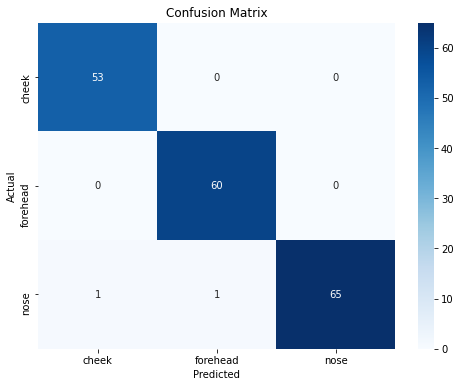

In [11]:
# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

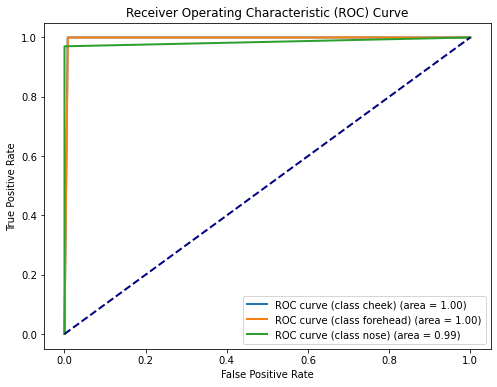

In [12]:
# One-hot 인코딩된 레이블을 다시 범주형 레이블로 변환
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# 이진 분류를 위해 레이블을 one-hot 인코딩
binary_y_test = label_binarize(y_test_labels, classes=np.arange(len(label_encoder.classes_)))
binary_y_pred = label_binarize(y_pred_labels, classes=np.arange(len(label_encoder.classes_)))

# 각 클래스에 대한 ROC 곡선 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(binary_y_test[:, i], binary_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))

for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {label_encoder.classes_[i]}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()